In [1]:
import timm
import logging
import time
import os
import sys
import time
import warnings
from contextlib import contextmanager
from pathlib import Path
from typing import List
from typing import Optional
from sklearn import metrics
from tqdm import tqdm
import random

from collections import defaultdict


import scipy
from IPython.display import Audio, display

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchaudio.functional as taF
import librosa
import torchaudio as ta

from torch_audiomentations import Compose, Gain, PolarityInversion, Shift
from audiomentations import Compose as Compose_aud
from audiomentations import Shift as Shift_aud
from audiomentations import Gain as Gain_aud
from audiomentations import Normalize as Normalize_aud
from audiomentations import AddGaussianNoise, TimeStretch, PitchShift, OneOf
from torchaudio import transforms as T


from typing import Callable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


path = '/home/acoustery/kf/noteb/kaggle/birds/'

#import noisereduce as nr
from ast import literal_eval as LE
from IPython.display import clear_output

from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_auc_score

from albumentations.core.transforms_interface import ImageOnlyTransform
#from torchlibrosa.stft import LogmelFilterBank, Spectrogram
#from torchlibrosa.augmentation import SpecAugmentation

#import transformers
import gc
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

from sklearn import metrics

#import transformers
from torch.cuda import amp
from torch.cuda.amp import autocast, GradScaler

In [2]:
class CFG:
    ######################
    # Globals #
    ######################
    seed = 42
    epochs = 80
    folds = [2,3,4] # [0, 1, 2, 3, 4]
    N_FOLDS = 15
    LR = 0.0008 #1e-3
    ETA_MIN = 1e-7
    WEIGHT_DECAY = 1e-5
    train_bs = 32 # 32
    valid_bs = train_bs*2 # 64
    base_model_name = "tf_efficientnet_b0_ns"
    EARLY_STOPPING = True
    DEBUG = False # True
    apex = True
    
    dropout = 0.4
    pooling = "max"
    pretrained = True
    num_classes = 152
    in_channels = 3
    target_columns = 'afrsil1 akekee akepa1 akiapo akikik amewig aniani apapan arcter \
                      barpet bcnher belkin1 bkbplo bknsti bkwpet blkfra blknod bongul \
                      brant brnboo brnnod brnowl brtcur bubsan buffle bulpet burpar buwtea \
                      cacgoo1 calqua cangoo canvas caster1 categr chbsan chemun chukar cintea \
                      comgal1 commyn compea comsan comwax coopet crehon dunlin elepai ercfra eurwig \
                      fragul gadwal gamqua glwgul gnwtea golphe grbher3 grefri gresca gryfra gwfgoo \
                      hawama hawcoo hawcre hawgoo hawhaw hawpet1 hoomer houfin houspa hudgod iiwi incter1 \
                      jabwar japqua kalphe kauama laugul layalb lcspet leasan leater1 lessca lesyel lobdow lotjae \
                      madpet magpet1 mallar3 masboo mauala maupar merlin mitpar moudov norcar norhar2 normoc norpin \
                      norsho nutman oahama omao osprey pagplo palila parjae pecsan peflov perfal pibgre pomjae puaioh \
                      reccar redava redjun redpha1 refboo rempar rettro ribgul rinduc rinphe rocpig rorpar rudtur ruff \
                      saffin sander semplo sheowl shtsan skylar snogoo sooshe sooter1 sopsku1 sora spodov sposan \
                      towsol wantat1 warwhe1 wesmea wessan wetshe whfibi whiter whttro wiltur yebcar yefcan zebdov'.split()
    
    scored = ["akiapo", "aniani", "apapan", "barpet", "crehon", "elepai", "ercfra", "hawama", "hawcre",
              "hawgoo", "hawhaw", "hawpet1", "houfin", "iiwi", "jabwar", "maupar", 
              "omao", "puaioh", "skylar", "warwhe1", "yefcan"]
    
    rare = ['omao', 'akiapo', 'barpet','hawama', 'elepai', 'aniani', 'hawgoo', 'ercfra', 'maupar',
            'hawpet1', 'hawhaw', 'crehon', 'puaioh']
    
    img_size = 224 # 128
    main_metric = "epoch_f1_at_03"

    period = 5
    n_mels = 224 # 128
    fmin = 20
    fmax = 16000
    n_fft = 2048
    hop_length = 501
    sample_rate = 32000
    melspectrogram_parameters = {
        "n_mels": 224, # 128,
        "fmin": 20,
        "fmax": 16000
    }
    
    cuda_num = 7
    device = torch.device(f'cuda:{cuda_num}')if torch.cuda.is_available() else torch.device('cpu')
    notebook_number = 7
    path_to_checks = '/home/acoustery/kf/noteb/kaggle/AST_m/checks/'
    
    base_dir = '/home/acoustery/kf/noteb/kaggle/AST_m/'
    
    seed_for_split = 1
    
    
    
class AudioParams:
    """
    Parameters used for the audio data
    """
    sr = CFG.sample_rate
    duration = CFG.period
    # Melspectrogram
    n_mels = CFG.n_mels
    fmin = CFG.fmin
    fmax = CFG.fmax
    hop_length = CFG.hop_length

In [3]:
train_data = pd.read_csv(CFG.base_dir + 'pseudo_df.csv').reset_index(drop=True)
train_data = train_data[train_data['logits'] > 0.8].reset_index(drop=True)
print(train_data.shape)
train_data.head()

(15966, 6)


,primary_label,secondary_labels,filename,kfold_raw,kfold_split,logits
0,afrsil1,[],/home/acoustery/data/kf/birds/all_aud/afrsil1/...,1,1,0.816120
1,afrsil1,[],/home/acoustery/data/kf/birds/all_aud/afrsil1/...,1,0,0.834092
2,afrsil1,[],/home/acoustery/data/kf/birds/all_aud/afrsil1/...,1,0,0.841536
3,afrsil1,[],/home/acoustery/data/kf/birds/all_aud/afrsil1/...,5,3,0.805498
4,afrsil1,[],/home/acoustery/data/kf/birds/all_aud/afrsil1/...,5,4,0.815090


In [4]:
import os

OUTPUT_DIR = '/home/acoustery/kf/noteb/kaggle/outputs'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
   
    
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(CFG.seed)
device = CFG.device


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

class MetricMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.y_true = []
        self.y_pred = []
    
    def update(self, y_true, y_pred):
        self.y_true.extend(y_true.cpu().detach().numpy().tolist())
        self.y_pred.extend(y_pred["clipwise_output"].cpu().detach().numpy().tolist())

    @property
    def avg(self):
        self.f1_005 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.05, average="micro")
        self.f1_01 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.1, average="micro")
        self.f1_015 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.15, average="micro")
        self.f1_02 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.2, average="micro")
        self.f1_025 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.25, average="micro")
        self.f1_03 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.3, average="micro")
        self.f1_035 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.35, average="micro")
        self.f1_04 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.4, average="micro")
        self.f1_045 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.45, average="micro")
        self.f1_05 = metrics.f1_score(np.array(self.y_true) == 1, np.array(self.y_pred) > 0.5, average="micro")
        
        return {
            "f1_at_005" : self.f1_005,
            "f1_at_01" : self.f1_01,
            "f1_at_015" : self.f1_015,
            "f1_at_02" : self.f1_02,
            "f1_at_025": self.f1_025,
            "f1_at_03": self.f1_03,
            "f1_at_035": self.f1_035,
            "f1_at_04": self.f1_04,
            "f1_at_045": self.f1_045,
            "f1_at_05": self.f1_05
        }
    
    
# https://www.kaggle.com/c/rfcx-species-audio-detection/discussion/213075
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, preds, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(preds, targets)
        probas = torch.sigmoid(preds)
        loss = targets * self.alpha * \
            (1. - probas)**self.gamma * bce_loss + \
            (1. - targets) * probas**self.gamma * bce_loss
        loss = loss.mean()
        return loss


class BCEFocal2WayLoss(nn.Module):
    def __init__(self, weights=[1, 1], class_weights=None):
        super().__init__()

        self.focal = BCEFocalLoss()

        self.weights = weights

    def forward(self, input, target):
        input_ = input["logit"]
        target = target.float()

        framewise_output = input["framewise_logit"]
        clipwise_output_with_max, _ = framewise_output.max(dim=1)

        loss = self.focal(input_, target)
        aux_loss = self.focal(clipwise_output_with_max, target)

        return self.weights[0] * loss + self.weights[1] * aux_loss


class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError
        
class NoiseInjection(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_level=0.5):
        super().__init__(always_apply, p)

        self.noise_level = (0.0, max_noise_level)

    def apply(self, y: np.ndarray, **params):
        noise_level = np.random.uniform(*self.noise_level)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_level).astype(y.dtype)
        return augmented
    

def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output


class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)


class Model_image(nn.Module):
    def __init__(self, base_model_name: str, pretrained=False, num_classes=24,
                 in_channels=1, dropout_rate=0.4):
        super().__init__()
        
        self._dropout_rate = dropout_rate
        
        self.bn0 = nn.BatchNorm2d(CFG.n_mels)

        base_model = timm.create_model(
            base_model_name, pretrained=pretrained, in_chans=in_channels)
        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        if hasattr(base_model, "fc"):
            in_features = base_model.fc.in_features
        else:
            in_features = base_model.classifier.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(
            in_features, num_classes, activation="sigmoid")

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        

    def forward(self, input_data):
        x = input_data # (batch_size, 3, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        x = x.transpose(2, 3)

        x = self.encoder(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=self._dropout_rate, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=self._dropout_rate, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        interpolate_ratio = frames_num // segmentwise_output.size(1)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            'framewise_output': framewise_output,
            'clipwise_output': clipwise_output,
            'logit': logit,
            'framewise_logit': framewise_logit,
        }

        return output_dict


In [5]:
audio_conf = {'num_mel_bins': 224, 'target_length': 512, 'freqm': 24, 'timem': 96, 
              'mixup': 0.4, 'skip_norm': True, 'mode': 'train', 'dataset': 'Birds custom',
             'mean': -6.98279, 'std': 3.05492, 'noise': True}


val_audio_conf = {'num_mel_bins': 224, 'target_length': 512, 'freqm': 0, 'timem': 0, 
              'mixup': -1, 'skip_norm': True, 'mode': 'eval', 'dataset': 'Birds custom',
             'mean': -6.98279, 'std': 3.05492, 'noise': False}


def crop_or_pad(y, sr=CFG.sample_rate, length=CFG.sample_rate*CFG.period, mode='train'):
    leny = y.size(1)
    if leny <= length:
        y = torch.nn.functional.pad(y, (0,length - leny), "constant", 0)
    else:
        if mode != 'train':
            start_ = 0
        else:        
            start_ = np.random.randint(leny - length)
        y = y[:, start_: start_ + length]
    return y



class AudiosetDataset(Dataset):
    def __init__(self, df_in: pd.DataFrame, audio_conf=audio_conf, label_csv=None):
        """
        Dataset that manages audio recordings
        :param audio_conf: Dictionary containing the audio loading and preprocessing settings
        :param dataset_json_file
        """
        self.data = df_in
        
        self.audio_conf = audio_conf
        
        self.mode = self.audio_conf.get('mode')
        print('---------------the {:s} dataloader---------------'.format(self.audio_conf.get('mode')))
        self.melbins = self.audio_conf.get('num_mel_bins')
        self.freqm = self.audio_conf.get('freqm')
        self.timem = self.audio_conf.get('timem')
        print('now using following mask: {:d} freq, {:d} time'.format(self.audio_conf.get('freqm'), 
                                                                      self.audio_conf.get('timem')))
        self.mixup = self.audio_conf.get('mixup')
        print('now using mix-up with rate {:f}'.format(self.mixup))
        self.dataset = self.audio_conf.get('dataset')
        print('now process ' + self.dataset)
        # dataset spectrogram mean and std, used to normalize the input
        self.norm_mean = self.audio_conf.get('mean')
        self.norm_std = self.audio_conf.get('std')
        print('use dataset mean {:.3f} and std {:.3f} to normalize the input'.format(self.norm_mean, self.norm_std))
        # if add noise for data augmentation
        self.noise = self.audio_conf.get('noise')
        if self.noise == True:
            print('now use noise augmentation')

        self.label_num = len(CFG.target_columns)
        print('number of classes is {:d}'.format(self.label_num))
        
        print(f'Dataset size: {df_in.shape[0]}')
        
        self.freqm_t = ta.transforms.FrequencyMasking(self.freqm)
        self.timem_t = ta.transforms.TimeMasking(self.timem)
        
        if self.mode == 'train':
            self.wave_transforms = Compose_aud([
                                OneOf([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.011, p=1),
                                NoiseInjection(p=1, max_noise_level=0.04)], p=0.4),
                                
                                PitchShift(min_semitones=-4, max_semitones=4, p=0.1),
                                Shift_aud(min_fraction=-0.5, max_fraction=0.5, p=0.1),
                                Gain_aud(min_gain_in_db=-12, max_gain_in_db=12, p=0.2),    
                                Normalize_aud(p=1.)

                            ])
        else:
            self.wave_transforms = Compose_aud([Normalize_aud(p=1)])
            
    def normis(self, clip, sr, SR_):
        if clip.size(0) != 1:
            clip = clip.mean(dim=0, keepdim=True)
            
        if sr != SR_:
            clip = taF.resample(clip, sr, SR_, lowpass_filter_width=64,
                                            rolloff=0.9475937167399596, resampling_method="kaiser_window",
                                            beta=14.769656459379492)
        return clip
        
    def _wav2fbank(self, filename, filename2=None):
            # mixup
            SR = 32000
            if filename2 == None:
                waveform, sr1 = ta.load(filename)
                waveform = self.normis(waveform, sr1, SR)
                waveform = crop_or_pad(waveform, sr=SR, mode=self.mode)
                waveform = waveform - waveform.mean()
            # mixup
            else:
                waveform1, sr1 = ta.load(filename)
                waveform1 = self.normis(waveform1, sr1, SR)
                waveform1 = crop_or_pad(waveform1, sr=SR, mode=self.mode)
                waveform2, sr2 = ta.load(filename2)
                waveform2 = self.normis(waveform2, sr2, SR)
                waveform2 = crop_or_pad(waveform2, sr=SR, mode=self.mode)

                waveform1 = waveform1 - waveform1.mean()
                waveform2 = waveform2 - waveform2.mean()

                # sample lambda from uniform distribution
                #mix_lambda = random.random()
                # sample lambda from beta distribtion
                mix_lambda = np.random.beta(10, 10)

                mix_waveform = mix_lambda * waveform1 + (1 - mix_lambda) * waveform2
                waveform = mix_waveform - mix_waveform.mean()
            
            waveform = torch.tensor(self.wave_transforms(samples=waveform[0].numpy(), sample_rate=SR)).unsqueeze(0)
            fbank = ta.compliance.kaldi.fbank(waveform, htk_compat=True, sample_frequency=SR, 
                                                      use_energy=False, window_type='hanning', 
                                                      num_mel_bins=self.melbins, dither=0.0, frame_shift=9.7)

            target_length = self.audio_conf.get('target_length')
            n_frames = fbank.shape[0]

            p = target_length - n_frames

            # cut and pad
            if p > 0:
                m = torch.nn.ZeroPad2d((0, 0, 0, p))
                fbank = m(fbank)
            elif p < 0:
                fbank = fbank[0:target_length, :]

            if filename2 == None:
                return fbank, 0
            else:
                return fbank, mix_lambda
            

    def __getitem__(self, index):
        """
        returns: image, audio, nframes
        where image is a FloatTensor of size (3, H, W)
        audio is a FloatTensor of size (N_freq, N_frames) for spectrogram, or (N_frames) for waveform
        nframes is an integer
        """
        # do mix-up for this sample (controlled by the given mixup rate) 
        
        if random.random() < self.mixup:
            datum = self.data.loc[index, :]
            mix_sample_idx = random.randint(0, len(self.data)-1)
            mix_datum = self.data.loc[mix_sample_idx, :]
            fbank, mix_lambda = self._wav2fbank(datum['filename'], mix_datum['filename'])
            
            label_indices = np.zeros(self.label_num)
            # add sample 1 labels
            for bird_code in LE(datum['secondary_labels']):
                label_indices[CFG.target_columns.index(bird_code)] += mix_lambda * 0.4
            label_indices[CFG.target_columns.index(datum['primary_label'])] += mix_lambda
            # add sample 2 labels
            for bird_code in LE(mix_datum['secondary_labels']):
                label_indices[CFG.target_columns.index(bird_code)] += (1.0-mix_lambda) * 0.4
            label_indices[CFG.target_columns.index(mix_datum['primary_label'])] += 1.0-mix_lambda
            
            label_indices = torch.FloatTensor(label_indices)
        # if not do mixup
        else:
            datum = self.data.loc[index, :]
            label_indices = np.zeros(self.label_num)
            fbank, mix_lambda = self._wav2fbank(datum['filename'])
            for bird_code in LE(datum['secondary_labels']):
                label_indices[CFG.target_columns.index(bird_code)] = 0.4
            label_indices[CFG.target_columns.index(datum['primary_label'])] = 1.

            label_indices = torch.FloatTensor(label_indices)

        # SpecAug, not do for eval set
        #freqm = torchaudio.transforms.FrequencyMasking(self.freqm)
        #timem = torchaudio.transforms.TimeMasking(self.timem)
        fbank = torch.transpose(fbank, 0, 1)
        fbank = fbank.unsqueeze(0)
        if self.freqm != 0:
            fbank = self.freqm_t(fbank)
        if self.timem != 0:
            fbank = self.timem_t(fbank)
        fbank = fbank.squeeze(0)
        fbank = torch.transpose(fbank, 0, 1)

        # normalize the input
        fbank = (fbank - self.norm_mean) / (self.norm_std * 2)

        if self.noise == True and False:
            fbank = fbank + torch.rand(fbank.shape[0], fbank.shape[1]) * np.random.rand() / 10
            fbank = torch.roll(fbank, np.random.randint(-10, 10), 0)

        mix_ratio = min(mix_lambda, 1-mix_lambda) / max(mix_lambda, 1-mix_lambda)

        # the output fbank shape is [time_frame_num, frequency_bins], e.g., [1024, 128]
        fbank = torch.stack([fbank, fbank, fbank])
        return {'image':fbank, 'targets':label_indices}
    
    
    def __len__(self):
        return len(self.data)

In [7]:
def create_weights_arr(dff, cols, max_count=100, max_weight=10, save=False):
    d_c = {}
    d_w = {}
    for b in cols:
        d_c[b] = dff[dff.primary_label == b].shape[0]
    
    for k in d_c:
        if d_c[k] == 0:
            ite = 1
        else:
            ite = max_count / d_c[k]
        if ite > max_weight:
            ite = max_weight
        elif ite < 1:
            ite = 1
        d_w[k] = ite
    weights_ar = []
    for bir in cols:
        weights_ar.append(d_w[bir])
    weights_ar = np.array(weights_ar)
    if save:
        np.save(f'{CFG.base_dir}PSEUDO_WGTS_{max_count}_{max_weight}.npy', weights_ar)
    return weights_ar

def make500(data, skok=500):
    all_idx = []
    for brd in CFG.target_columns:
        sub_d = list(data[data.primary_label == brd].index)
        random.shuffle(sub_d)
        all_idx.extend(sub_d[:skok])
    return data.loc[all_idx, :].reset_index(drop=True)

audio_conf = {'num_mel_bins': 224, 'target_length': 512, 'freqm': 24, 'timem': 96, 
              'mixup': 0.3, 'skip_norm': True, 'mode': 'train', 'dataset': 'Birds custom',
             'mean': -6.98279, 'std': 3.05492, 'noise': True}


val_audio_conf = {'num_mel_bins': 224, 'target_length': 512, 'freqm': 0, 'timem': 0, 
              'mixup': -1, 'skip_norm': True, 'mode': 'eval', 'dataset': 'Birds custom',
             'mean': -6.98279, 'std': 3.05492, 'noise': False}


def prepare_loaders(df, fold, epoch, fold_type, r_saml=False, use_rare=False, use_500=False):
    #fold types: kfold_raw   kfold_split
    #if use_rare:
    #    train_df = df.query(f"{fold_type}!=@fold").reset_index(drop=True)
    #    valid_df = df.query(f"{fold_type}==@fold").reset_index(drop=True)
    #else:
    #    train_df = df[(df[fold_type] != fold) | (df.primary_label.isin(CFG.rare))].reset_index(drop=True)
    #    valid_df = df[(df[fold_type] == fold) & ~(df.primary_label.isin(CFG.rare))].reset_index(drop=True)
        
    
    train_df = make500(df, 300)
    maks_for_weig = 300    
    valid_df = make500(df, 10)
    
    valid_target = make500(df[df.primary_label.isin(CFG.scored)], 40)
    
    weig = create_weights_arr(train_df, CFG.target_columns, maks_for_weig, 15, True)  
    if r_saml:
        ww = np.ones(len(CFG.target_columns))
        ww[np.isin(CFG.target_columns, CFG.scored).nonzero()[0]] = weig[np.isin(CFG.target_columns, 
                                                                                CFG.scored).nonzero()[0]]
        ww = ww/ww.max()

        target = train_df.primary_label.values
        samples_weight = np.array([ww[CFG.target_columns.index(t)] for t in target])

        samples_weight = torch.from_numpy(samples_weight)
        samples_weigth = samples_weight.double()
        sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
        shuffler = False
    else:
        sampler = None
        shuffler = True
        
    if epoch < 15:
        cur_mixup = 0.4
    elif 15 <= epoch < 20:
        cur_mixup = 0.07
    else:
        cur_mixup = 0.
        
    cur_audio_conf = {'num_mel_bins': 224, 'target_length': 512, 'freqm': 24, 'timem': 96, 
              'mixup': cur_mixup, 'skip_norm': True, 'mode': 'train', 'dataset': 'Birds custom',
             'mean': -6.98279, 'std': 3.05492, 'noise': True}
        
        
    train_dataset = AudiosetDataset(train_df, cur_audio_conf)
    valid_dataset = AudiosetDataset(valid_df, val_audio_conf)
    target_dataset = AudiosetDataset(valid_target, val_audio_conf)
    
    print(f'Length train dataset: {len(train_dataset)}')
    print(f'Length valid dataset: {len(valid_dataset)}')
    print(f'Length target dataset: {len(target_dataset)}')
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=shuffler,
                                               sampler=sampler, pin_memory=True, drop_last=True)
    
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CFG.valid_bs, shuffle=False,
                                               pin_memory=True)
    
    target_loader = torch.utils.data.DataLoader(target_dataset, batch_size=CFG.valid_bs, shuffle=False,
                                               pin_memory=True)
   
    
    return train_loader, valid_loader, target_loader


In [9]:
train_loader, valid_loader, target_loader = prepare_loaders(train_data, 0, 0, 
                                                            'kfold_raw', r_saml=False, use_rare=False, use_500=True)

---------------the train dataloader---------------
now using following mask: 24 freq, 96 time
now using mix-up with rate 0.400000
now process Birds custom
use dataset mean -6.983 and std 3.055 to normalize the input
now use noise augmentation
number of classes is 152
Dataset size: 13340
---------------the eval dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate -1.000000
now process Birds custom
use dataset mean -6.983 and std 3.055 to normalize the input
number of classes is 152
Dataset size: 1268
---------------the eval dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate -1.000000
now process Birds custom
use dataset mean -6.983 and std 3.055 to normalize the input
number of classes is 152
Dataset size: 743
Length train dataset: 13340
Length valid dataset: 1268
Length target dataset: 743


torch.Size([32, 3, 512, 224]) torch.Size([32, 152])


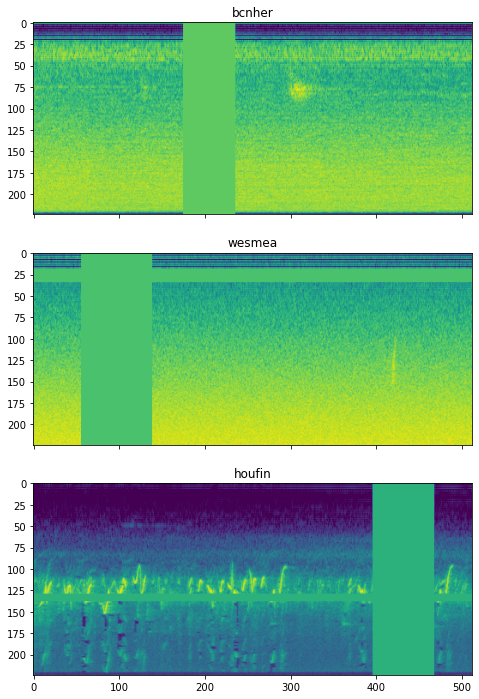

In [11]:
import matplotlib.pyplot as plt
batch = next(iter(train_loader))
print(batch['image'].size(), batch['targets'].size())
def plot_batch(imgs, msks, size=3):
    fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(15, 12))
    for idx in range(size):
        axs[idx].set_title(CFG.target_columns[torch.argmax(msks[idx]).item()])
        img = imgs[idx].transpose(1,2)[0].numpy()
        #print(img.shape)
        axs[idx].imshow(img)
        #img = img.astype('uint8')
        #msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        #plt.legend(CFG.target_columns[torch.argmax(msks[0]).item()])
        #plt.imshow(img)
    #plt.show()
plot_batch(batch['image'], batch['targets'], size=3)

In [12]:
len_train_loader = len(train_loader)
print(len_train_loader)
del train_loader, valid_loader, target_loader

416


In [13]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, warmup=False):
    model.train()
    scaler = amp.GradScaler(enabled=True)
    
    warmup = False  ##
    
    losses = AverageMeter()
    scores = MetricMeter()
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (data) in pbar:    
        
        inputs = data['image'].to(device)
        targets = data['targets'].to(device)
        
        B = inputs.size(0) 
        
        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            
    
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #scheduler.step()
        
        losses.update(loss.item(), B)
        scores.update(targets, outputs)    
        
        mem = torch.cuda.memory_reserved(f'cuda:{CFG.cuda_num}') / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{losses.avg:0.6f}',
                        lr=f'{current_lr:0.6f}',
                        gpu_mem=f'{mem:0.2f} GB')
        torch.cuda.empty_cache()
        gc.collect()
        
    scheduler.step()
    return scores.avg, losses.avg

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    losses = AverageMeter()
    scores = MetricMeter()
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (data) in pbar:    
        
        inputs = data['image'].to(device)
        targets = data['targets'].to(device)
        
        B = inputs.size(0) 
            #print('warm-up learning rate is {:f}'.format(optimizer.param_groups[0]['lr']))
        
        with amp.autocast(enabled=True):
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

        
        losses.update(loss.item(), B)
        scores.update(targets, outputs)
        
        mem = torch.cuda.memory_reserved(f'cuda:{CFG.cuda_num}') / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{losses.avg:0.6f}',
                        lr=f'{current_lr:0.6f}',
                        gpu_memory=f'{mem:0.2f} GB')

    torch.cuda.empty_cache()
    gc.collect()
    
    return scores.avg, losses.avg

In [15]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold, warmup=False):
    # To automatically log gradients
    #wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name(f'cuda:{CFG.cuda_num}')))
    
    start = time.time()
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_score_train   = -np.inf
    best_score_valid   = -np.inf
    best_score_target  = -np.inf
    min_loss       = 10000
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}')
        
        start_time = time.time()
        
        train_loader, valid_loader, target_loader = prepare_loaders(train_data, fold, epoch, 'kfold_raw',
                                                                 r_saml=False, use_rare=False, use_500=True)
        
        train_avg, train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch, warmup=warmup)
        
        valid_avg, valid_loss = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        
        target_avg, target_loss = valid_one_epoch(model, target_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)

        
        elapsed = time.time() - start_time
        
        print('TRAIN SCORES:')
        print(f'Epoch {epoch} - avg_train_loss: {train_loss:.5f} time: {elapsed:.0f}s')
        print(f"Epoch {epoch} - valid_f1_at_005:{train_avg['f1_at_005']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_01:{train_avg['f1_at_01']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_015:{train_avg['f1_at_015']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_02:{train_avg['f1_at_02']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_025:{train_avg['f1_at_025']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_03:{train_avg['f1_at_03']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_035:{train_avg['f1_at_035']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_04:{train_avg['f1_at_04']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_045:{train_avg['f1_at_045']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_05:{train_avg['f1_at_05']:0.5f}")
        
        print('='*50)
        
        print('VALIDATION SCORES:')
        print(f'Epoch {epoch} - avg_val_loss: {valid_loss:.5f}')
        print(f"Epoch {epoch} - valid_f1_at_005:{valid_avg['f1_at_005']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_01:{valid_avg['f1_at_01']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_015:{valid_avg['f1_at_015']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_02:{valid_avg['f1_at_02']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_025:{valid_avg['f1_at_025']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_03:{valid_avg['f1_at_03']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_035:{valid_avg['f1_at_035']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_04:{valid_avg['f1_at_04']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_045:{valid_avg['f1_at_045']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_05:{valid_avg['f1_at_05']:0.5f}")
        
        
        print('TARGET SCORES:')
        print(f'Epoch {epoch} - avg_train_loss: {target_loss:.5f}  ')
        print(f"Epoch {epoch} - valid_f1_at_005:{target_avg['f1_at_005']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_01:{target_avg['f1_at_01']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_015:{target_avg['f1_at_015']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_02:{target_avg['f1_at_02']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_025:{target_avg['f1_at_025']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_03:{target_avg['f1_at_03']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_035:{target_avg['f1_at_035']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_04:{target_avg['f1_at_04']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_045:{target_avg['f1_at_045']:0.5f}")
        print(f"Epoch {epoch}x - valid_f1_at_05:{target_avg['f1_at_05']:0.5f}")
        # deep copy the model
        if valid_avg['f1_at_03'] >= best_score_valid:
            print(f"{c_}Valid Score 03 Improved ({best_score_valid:0.4f} ---> {valid_avg['f1_at_03']:0.4f})")
            best_score_valid    = valid_avg['f1_at_03']
        
            best_epoch   = epoch

            PATH = f"{CFG.path_to_checks}PSEUDO_VALID_03BEST.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved here: {PATH}{sr_}")
        else:
            print(f"Valid Score 03 Not Improved, still: {best_score_valid:0.4f}")
            
        if target_avg['f1_at_03'] >= best_score_target:
            print(f"{c_}Target Score 03 Improved ({best_score_target:0.4f} ---> {target_avg['f1_at_03']:0.4f})")
            best_score_target = target_avg['f1_at_03']        
            best_epoch    = epoch

            PATH = f"{CFG.path_to_checks}PSEUDO_TARGET_03BEST.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved here: {PATH}{sr_}")
        else:
            print(f"Target Score 03 Not Improved, still: {best_score_target:0.4f}")
            
        if train_avg['f1_at_03'] >= best_score_train:
            print(f"{c_}Train Score 03 Improved ({best_score_train:0.4f} ---> {train_avg['f1_at_03']:0.4f})")
            best_score_train = train_avg['f1_at_03']        
            best_epoch    = epoch

            PATH = f"{CFG.path_to_checks}PSEUDO_TRAIN_03BEST.bin"
            torch.save(model.state_dict(), PATH)
            print(f"Model Saved here: {PATH}{sr_}")
        else:
            print(f"Train Score 03 Not Improved, still: {best_score_train:0.4f}")
            
        
        
        PATH = f"{CFG.path_to_checks}PSEUDO_last_epoch.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    # load best model weights
    #model.load_state_dict(best_model_wts)
    
    return model, history

In [16]:
trans = False

for fold in CFG.folds:
    if fold == 2:
        trans = True
        LR = 0.00055
        min_LR = CFG.ETA_MIN
        epchs = 30
        warmup = False
    else:
        trans = False
        LR = CFG.LR 
        min_LR = CFG.ETA_MIN
        epchs = CFG.epochs
        warmup = False
        
    #T_MAX_ = len_train_loader * epchs + 50    
    torch.cuda.empty_cache()
    print(f'#'*15)
    print(f'### Fold: {fold} from {CFG.folds}')
    print(f'#'*15)
    
    model = Model_image(
                    base_model_name=CFG.base_model_name,
                    pretrained=CFG.pretrained,
                    num_classes=CFG.num_classes,
                    in_channels=CFG.in_channels,
                    dropout_rate=CFG.dropout)
    model.to(CFG.device)
    if trans:
        warmup = False
        print('You loading checkpoint, set the lower LR\n')
        model.load_state_dict(torch.load(f'{CFG.path_to_checks}SEDMIX_check.bin'))
        
    trainables = [p for p in model.parameters() if p.requires_grad]
    print('Total parameter number is : {:.3f} million'.format(sum(p.numel() for p in model.parameters()) / 1e6))
    print('Total trainable parameter number is : {:.3f} million'.format(sum(p.numel() for p in trainables) / 1e6))
    optimizer = torch.optim.Adam(trainables, lr=LR, weight_decay=5e-7, betas=(0.95, 0.999))
    
    
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 15, 20, 25, 30], gamma=0.6, last_epoch=-1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epchs, last_epoch=-1, eta_min=min_LR)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=epchs, fold=fold, warmup=warmup)
    

###############
### Fold: 999 from [2, 3, 4]
###############
Total parameter number is : 6.037 million
Total trainable parameter number is : 6.037 million
cuda: Tesla V100-SXM2-16GB

Epoch 1/85
---------------the train dataloader---------------
now using following mask: 24 freq, 96 time
now using mix-up with rate 0.400000
now process Birds custom
use dataset mean -6.983 and std 3.055 to normalize the input
now use noise augmentation
number of classes is 152
Dataset size: 13340
---------------the eval dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate -1.000000
now process Birds custom
use dataset mean -6.983 and std 3.055 to normalize the input
number of classes is 152
Dataset size: 1268
---------------the eval dataloader---------------
now using following mask: 0 freq, 0 time
now using mix-up with rate -1.000000
now process Birds custom
use dataset mean -6.983 and std 3.055 to normalize the input
number of classes is 152
Dataset size: 743
Len

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.72it/s, gpu_memory=3.80 GB, lr=0.001400, valid_loss=0.008331]


TRAIN SCORES:
Epoch 1 - avg_train_loss: 0.01353 time: 698s
Epoch 1 - valid_f1_at_005:0.01719
Epoch 1x - valid_f1_at_01:0.03874
Epoch 1x - valid_f1_at_015:0.02196
Epoch 1x - valid_f1_at_02:0.00866
Epoch 1x - valid_f1_at_025:0.00510
Epoch 1x - valid_f1_at_03:0.00405
Epoch 1x - valid_f1_at_035:0.00295
Epoch 1x - valid_f1_at_04:0.00280
Epoch 1x - valid_f1_at_045:0.00204
Epoch 1x - valid_f1_at_05:0.00166
VALIDATION SCORES:
Epoch 1 - avg_val_loss: 0.00828
Epoch 1 - valid_f1_at_005:0.02090
Epoch 1x - valid_f1_at_01:0.04730
Epoch 1x - valid_f1_at_015:0.08525
Epoch 1x - valid_f1_at_02:0.08442
Epoch 1x - valid_f1_at_025:0.04993
Epoch 1x - valid_f1_at_03:0.02450
Epoch 1x - valid_f1_at_035:0.02019
Epoch 1x - valid_f1_at_04:0.00783
Epoch 1x - valid_f1_at_045:0.00157
Epoch 1x - valid_f1_at_05:0.00000
TARGET SCORES:
Epoch 1 - avg_train_loss: 0.00833  
Epoch 1 - valid_f1_at_005:0.02531
Epoch 1x - valid_f1_at_01:0.04945
Epoch 1x - valid_f1_at_015:0.07582
Epoch 1x - valid_f1_at_02:0.08155
Epoch 1x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.76it/s, gpu_memory=3.80 GB, lr=0.001398, valid_loss=0.006883]


TRAIN SCORES:
Epoch 2 - avg_train_loss: 0.00620 time: 681s
Epoch 2 - valid_f1_at_005:0.02317
Epoch 2x - valid_f1_at_01:0.09095
Epoch 2x - valid_f1_at_015:0.18413
Epoch 2x - valid_f1_at_02:0.15401
Epoch 2x - valid_f1_at_025:0.09447
Epoch 2x - valid_f1_at_03:0.05718
Epoch 2x - valid_f1_at_035:0.03294
Epoch 2x - valid_f1_at_04:0.02107
Epoch 2x - valid_f1_at_045:0.01331
Epoch 2x - valid_f1_at_05:0.00939
VALIDATION SCORES:
Epoch 2 - avg_val_loss: 0.00706
Epoch 2 - valid_f1_at_005:0.03659
Epoch 2x - valid_f1_at_01:0.09186
Epoch 2x - valid_f1_at_015:0.17978
Epoch 2x - valid_f1_at_02:0.24556
Epoch 2x - valid_f1_at_025:0.21915
Epoch 2x - valid_f1_at_03:0.18134
Epoch 2x - valid_f1_at_035:0.13296
Epoch 2x - valid_f1_at_04:0.09212
Epoch 2x - valid_f1_at_045:0.07132
Epoch 2x - valid_f1_at_05:0.05215
TARGET SCORES:
Epoch 2 - avg_train_loss: 0.00688  
Epoch 2 - valid_f1_at_005:0.04532
Epoch 2x - valid_f1_at_01:0.11653
Epoch 2x - valid_f1_at_015:0.20392
Epoch 2x - valid_f1_at_02:0.24447
Epoch 2x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.74it/s, gpu_memory=3.80 GB, lr=0.001396, valid_loss=0.005091]


TRAIN SCORES:
Epoch 3 - avg_train_loss: 0.00535 time: 693s
Epoch 3 - valid_f1_at_005:0.03283
Epoch 3x - valid_f1_at_01:0.13116
Epoch 3x - valid_f1_at_015:0.27769
Epoch 3x - valid_f1_at_02:0.32141
Epoch 3x - valid_f1_at_025:0.27466
Epoch 3x - valid_f1_at_03:0.20888
Epoch 3x - valid_f1_at_035:0.15308
Epoch 3x - valid_f1_at_04:0.10617
Epoch 3x - valid_f1_at_045:0.07091
Epoch 3x - valid_f1_at_05:0.04457
VALIDATION SCORES:
Epoch 3 - avg_val_loss: 0.00534
Epoch 3 - valid_f1_at_005:0.05477
Epoch 3x - valid_f1_at_01:0.17789
Epoch 3x - valid_f1_at_015:0.32731
Epoch 3x - valid_f1_at_02:0.39434
Epoch 3x - valid_f1_at_025:0.39559
Epoch 3x - valid_f1_at_03:0.34615
Epoch 3x - valid_f1_at_035:0.28590
Epoch 3x - valid_f1_at_04:0.23378
Epoch 3x - valid_f1_at_045:0.17784
Epoch 3x - valid_f1_at_05:0.13567
TARGET SCORES:
Epoch 3 - avg_train_loss: 0.00509  
Epoch 3 - valid_f1_at_005:0.06584
Epoch 3x - valid_f1_at_01:0.21251
Epoch 3x - valid_f1_at_015:0.35442
Epoch 3x - valid_f1_at_02:0.39841
Epoch 3x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.73it/s, gpu_memory=3.80 GB, lr=0.001394, valid_loss=0.004206]


TRAIN SCORES:
Epoch 4 - avg_train_loss: 0.00475 time: 703s
Epoch 4 - valid_f1_at_005:0.04038
Epoch 4x - valid_f1_at_01:0.15665
Epoch 4x - valid_f1_at_015:0.32084
Epoch 4x - valid_f1_at_02:0.40117
Epoch 4x - valid_f1_at_025:0.39164
Epoch 4x - valid_f1_at_03:0.34371
Epoch 4x - valid_f1_at_035:0.28703
Epoch 4x - valid_f1_at_04:0.23449
Epoch 4x - valid_f1_at_045:0.17449
Epoch 4x - valid_f1_at_05:0.12008
VALIDATION SCORES:
Epoch 4 - avg_val_loss: 0.00447
Epoch 4 - valid_f1_at_005:0.06349
Epoch 4x - valid_f1_at_01:0.20787
Epoch 4x - valid_f1_at_015:0.39089
Epoch 4x - valid_f1_at_02:0.47930
Epoch 4x - valid_f1_at_025:0.50448
Epoch 4x - valid_f1_at_03:0.48564
Epoch 4x - valid_f1_at_035:0.44891
Epoch 4x - valid_f1_at_04:0.37273
Epoch 4x - valid_f1_at_045:0.30810
Epoch 4x - valid_f1_at_05:0.25736
TARGET SCORES:
Epoch 4 - avg_train_loss: 0.00421  
Epoch 4 - valid_f1_at_005:0.07270
Epoch 4x - valid_f1_at_01:0.23113
Epoch 4x - valid_f1_at_015:0.40350
Epoch 4x - valid_f1_at_02:0.51867
Epoch 4x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.73it/s, gpu_memory=3.80 GB, lr=0.001390, valid_loss=0.003427]


TRAIN SCORES:
Epoch 5 - avg_train_loss: 0.00438 time: 671s
Epoch 5 - valid_f1_at_005:0.04591
Epoch 5x - valid_f1_at_01:0.17750
Epoch 5x - valid_f1_at_015:0.35170
Epoch 5x - valid_f1_at_02:0.44978
Epoch 5x - valid_f1_at_025:0.46122
Epoch 5x - valid_f1_at_03:0.42490
Epoch 5x - valid_f1_at_035:0.36900
Epoch 5x - valid_f1_at_04:0.30493
Epoch 5x - valid_f1_at_045:0.24268
Epoch 5x - valid_f1_at_05:0.17990
VALIDATION SCORES:
Epoch 5 - avg_val_loss: 0.00385
Epoch 5 - valid_f1_at_005:0.08725
Epoch 5x - valid_f1_at_01:0.27964
Epoch 5x - valid_f1_at_015:0.47791
Epoch 5x - valid_f1_at_02:0.57466
Epoch 5x - valid_f1_at_025:0.60552
Epoch 5x - valid_f1_at_03:0.56460
Epoch 5x - valid_f1_at_035:0.51942
Epoch 5x - valid_f1_at_04:0.46686
Epoch 5x - valid_f1_at_045:0.41350
Epoch 5x - valid_f1_at_05:0.34345
TARGET SCORES:
Epoch 5 - avg_train_loss: 0.00343  
Epoch 5 - valid_f1_at_005:0.10121
Epoch 5x - valid_f1_at_01:0.33140
Epoch 5x - valid_f1_at_015:0.56576
Epoch 5x - valid_f1_at_02:0.67629
Epoch 5x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.75it/s, gpu_memory=3.80 GB, lr=0.001386, valid_loss=0.002813]


TRAIN SCORES:
Epoch 6 - avg_train_loss: 0.00415 time: 695s
Epoch 6 - valid_f1_at_005:0.04869
Epoch 6x - valid_f1_at_01:0.18683
Epoch 6x - valid_f1_at_015:0.37036
Epoch 6x - valid_f1_at_02:0.47776
Epoch 6x - valid_f1_at_025:0.49891
Epoch 6x - valid_f1_at_03:0.47356
Epoch 6x - valid_f1_at_035:0.42554
Epoch 6x - valid_f1_at_04:0.36612
Epoch 6x - valid_f1_at_045:0.29847
Epoch 6x - valid_f1_at_05:0.23361
VALIDATION SCORES:
Epoch 6 - avg_val_loss: 0.00333
Epoch 6 - valid_f1_at_005:0.10805
Epoch 6x - valid_f1_at_01:0.33148
Epoch 6x - valid_f1_at_015:0.52832
Epoch 6x - valid_f1_at_02:0.63696
Epoch 6x - valid_f1_at_025:0.65423
Epoch 6x - valid_f1_at_03:0.64031
Epoch 6x - valid_f1_at_035:0.60429
Epoch 6x - valid_f1_at_04:0.55284
Epoch 6x - valid_f1_at_045:0.49354
Epoch 6x - valid_f1_at_05:0.42327
TARGET SCORES:
Epoch 6 - avg_train_loss: 0.00281  
Epoch 6 - valid_f1_at_005:0.12614
Epoch 6x - valid_f1_at_01:0.36661
Epoch 6x - valid_f1_at_015:0.59357
Epoch 6x - valid_f1_at_02:0.71656
Epoch 6x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.76it/s, gpu_memory=3.80 GB, lr=0.001381, valid_loss=0.003024]


TRAIN SCORES:
Epoch 7 - avg_train_loss: 0.00400 time: 687s
Epoch 7 - valid_f1_at_005:0.05132
Epoch 7x - valid_f1_at_01:0.19635
Epoch 7x - valid_f1_at_015:0.38486
Epoch 7x - valid_f1_at_02:0.49963
Epoch 7x - valid_f1_at_025:0.52986
Epoch 7x - valid_f1_at_03:0.50828
Epoch 7x - valid_f1_at_035:0.46737
Epoch 7x - valid_f1_at_04:0.40311
Epoch 7x - valid_f1_at_045:0.33517
Epoch 7x - valid_f1_at_05:0.25430
VALIDATION SCORES:
Epoch 7 - avg_val_loss: 0.00345
Epoch 7 - valid_f1_at_005:0.10856
Epoch 7x - valid_f1_at_01:0.33344
Epoch 7x - valid_f1_at_015:0.52143
Epoch 7x - valid_f1_at_02:0.62653
Epoch 7x - valid_f1_at_025:0.64673
Epoch 7x - valid_f1_at_03:0.63330
Epoch 7x - valid_f1_at_035:0.60073
Epoch 7x - valid_f1_at_04:0.55263
Epoch 7x - valid_f1_at_045:0.49391
Epoch 7x - valid_f1_at_05:0.42796
TARGET SCORES:
Epoch 7 - avg_train_loss: 0.00302  
Epoch 7 - valid_f1_at_005:0.11872
Epoch 7x - valid_f1_at_01:0.34168
Epoch 7x - valid_f1_at_015:0.53187
Epoch 7x - valid_f1_at_02:0.65338
Epoch 7x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.72it/s, gpu_memory=3.80 GB, lr=0.001375, valid_loss=0.002581]


TRAIN SCORES:
Epoch 8 - avg_train_loss: 0.00388 time: 674s
Epoch 8 - valid_f1_at_005:0.05270
Epoch 8x - valid_f1_at_01:0.20227
Epoch 8x - valid_f1_at_015:0.39643
Epoch 8x - valid_f1_at_02:0.51197
Epoch 8x - valid_f1_at_025:0.54210
Epoch 8x - valid_f1_at_03:0.52673
Epoch 8x - valid_f1_at_035:0.48912
Epoch 8x - valid_f1_at_04:0.43069
Epoch 8x - valid_f1_at_045:0.36364
Epoch 8x - valid_f1_at_05:0.29023
VALIDATION SCORES:
Epoch 8 - avg_val_loss: 0.00282
Epoch 8 - valid_f1_at_005:0.12028
Epoch 8x - valid_f1_at_01:0.36521
Epoch 8x - valid_f1_at_015:0.56713
Epoch 8x - valid_f1_at_02:0.68953
Epoch 8x - valid_f1_at_025:0.72720
Epoch 8x - valid_f1_at_03:0.71270
Epoch 8x - valid_f1_at_035:0.68883
Epoch 8x - valid_f1_at_04:0.64758
Epoch 8x - valid_f1_at_045:0.59166
Epoch 8x - valid_f1_at_05:0.51425
TARGET SCORES:
Epoch 8 - avg_train_loss: 0.00258  
Epoch 8 - valid_f1_at_005:0.13401
Epoch 8x - valid_f1_at_01:0.39298
Epoch 8x - valid_f1_at_015:0.61806
Epoch 8x - valid_f1_at_02:0.75286
Epoch 8x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.72it/s, gpu_memory=3.80 GB, lr=0.001368, valid_loss=0.002321]


TRAIN SCORES:
Epoch 9 - avg_train_loss: 0.00376 time: 670s
Epoch 9 - valid_f1_at_005:0.05308
Epoch 9x - valid_f1_at_01:0.20984
Epoch 9x - valid_f1_at_015:0.40959
Epoch 9x - valid_f1_at_02:0.51890
Epoch 9x - valid_f1_at_025:0.55393
Epoch 9x - valid_f1_at_03:0.53979
Epoch 9x - valid_f1_at_035:0.50183
Epoch 9x - valid_f1_at_04:0.45444
Epoch 9x - valid_f1_at_045:0.38940
Epoch 9x - valid_f1_at_05:0.31509
VALIDATION SCORES:
Epoch 9 - avg_val_loss: 0.00301
Epoch 9 - valid_f1_at_005:0.10952
Epoch 9x - valid_f1_at_01:0.35876
Epoch 9x - valid_f1_at_015:0.57062
Epoch 9x - valid_f1_at_02:0.66838
Epoch 9x - valid_f1_at_025:0.69475
Epoch 9x - valid_f1_at_03:0.68087
Epoch 9x - valid_f1_at_035:0.64870
Epoch 9x - valid_f1_at_04:0.60791
Epoch 9x - valid_f1_at_045:0.53622
Epoch 9x - valid_f1_at_05:0.46763
TARGET SCORES:
Epoch 9 - avg_train_loss: 0.00232  
Epoch 9 - valid_f1_at_005:0.12954
Epoch 9x - valid_f1_at_01:0.39126
Epoch 9x - valid_f1_at_015:0.63192
Epoch 9x - valid_f1_at_02:0.74899
Epoch 9x - val

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.76it/s, gpu_memory=3.80 GB, lr=0.001361, valid_loss=0.002384]


TRAIN SCORES:
Epoch 10 - avg_train_loss: 0.00372 time: 675s
Epoch 10 - valid_f1_at_005:0.05330
Epoch 10x - valid_f1_at_01:0.21170
Epoch 10x - valid_f1_at_015:0.41386
Epoch 10x - valid_f1_at_02:0.53474
Epoch 10x - valid_f1_at_025:0.56927
Epoch 10x - valid_f1_at_03:0.55693
Epoch 10x - valid_f1_at_035:0.52360
Epoch 10x - valid_f1_at_04:0.47258
Epoch 10x - valid_f1_at_045:0.40144
Epoch 10x - valid_f1_at_05:0.32592
VALIDATION SCORES:
Epoch 10 - avg_val_loss: 0.00266
Epoch 10 - valid_f1_at_005:0.13843
Epoch 10x - valid_f1_at_01:0.40178
Epoch 10x - valid_f1_at_015:0.57958
Epoch 10x - valid_f1_at_02:0.67983
Epoch 10x - valid_f1_at_025:0.72019
Epoch 10x - valid_f1_at_03:0.72339
Epoch 10x - valid_f1_at_035:0.71846
Epoch 10x - valid_f1_at_04:0.69269
Epoch 10x - valid_f1_at_045:0.64859
Epoch 10x - valid_f1_at_05:0.61388
TARGET SCORES:
Epoch 10 - avg_train_loss: 0.00238  
Epoch 10 - valid_f1_at_005:0.17754
Epoch 10x - valid_f1_at_01:0.46204
Epoch 10x - valid_f1_at_015:0.63706
Epoch 10x - valid_f1_a

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.75it/s, gpu_memory=3.80 GB, lr=0.001353, valid_loss=0.002476]


TRAIN SCORES:
Epoch 11 - avg_train_loss: 0.00368 time: 676s
Epoch 11 - valid_f1_at_005:0.05327
Epoch 11x - valid_f1_at_01:0.21177
Epoch 11x - valid_f1_at_015:0.41390
Epoch 11x - valid_f1_at_02:0.53401
Epoch 11x - valid_f1_at_025:0.56631
Epoch 11x - valid_f1_at_03:0.55994
Epoch 11x - valid_f1_at_035:0.52604
Epoch 11x - valid_f1_at_04:0.47785
Epoch 11x - valid_f1_at_045:0.41409
Epoch 11x - valid_f1_at_05:0.34549
VALIDATION SCORES:
Epoch 11 - avg_val_loss: 0.00260
Epoch 11 - valid_f1_at_005:0.11011
Epoch 11x - valid_f1_at_01:0.38037
Epoch 11x - valid_f1_at_015:0.61072
Epoch 11x - valid_f1_at_02:0.72808
Epoch 11x - valid_f1_at_025:0.74614
Epoch 11x - valid_f1_at_03:0.72147
Epoch 11x - valid_f1_at_035:0.67839
Epoch 11x - valid_f1_at_04:0.63219
Epoch 11x - valid_f1_at_045:0.58324
Epoch 11x - valid_f1_at_05:0.51830
TARGET SCORES:
Epoch 11 - avg_train_loss: 0.00248  
Epoch 11 - valid_f1_at_005:0.11196
Epoch 11x - valid_f1_at_01:0.38290
Epoch 11x - valid_f1_at_015:0.61991
Epoch 11x - valid_f1_a

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.77it/s, gpu_memory=3.80 GB, lr=0.001344, valid_loss=0.002615]


TRAIN SCORES:
Epoch 12 - avg_train_loss: 0.00365 time: 687s
Epoch 12 - valid_f1_at_005:0.05290
Epoch 12x - valid_f1_at_01:0.21340
Epoch 12x - valid_f1_at_015:0.41809
Epoch 12x - valid_f1_at_02:0.53360
Epoch 12x - valid_f1_at_025:0.57223
Epoch 12x - valid_f1_at_03:0.56696
Epoch 12x - valid_f1_at_035:0.53020
Epoch 12x - valid_f1_at_04:0.47758
Epoch 12x - valid_f1_at_045:0.41691
Epoch 12x - valid_f1_at_05:0.34864
VALIDATION SCORES:
Epoch 12 - avg_val_loss: 0.00289
Epoch 12 - valid_f1_at_005:0.13761
Epoch 12x - valid_f1_at_01:0.38385
Epoch 12x - valid_f1_at_015:0.58011
Epoch 12x - valid_f1_at_02:0.67810
Epoch 12x - valid_f1_at_025:0.72211
Epoch 12x - valid_f1_at_03:0.71353
Epoch 12x - valid_f1_at_035:0.68346
Epoch 12x - valid_f1_at_04:0.65895
Epoch 12x - valid_f1_at_045:0.61367
Epoch 12x - valid_f1_at_05:0.57048
TARGET SCORES:
Epoch 12 - avg_train_loss: 0.00262  
Epoch 12 - valid_f1_at_005:0.15129
Epoch 12x - valid_f1_at_01:0.37308
Epoch 12x - valid_f1_at_015:0.56351
Epoch 12x - valid_f1_a

Valid : 100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:06<00:00,  1.75it/s, gpu_memory=3.80 GB, lr=0.001335, valid_loss=0.002786]


TRAIN SCORES:
Epoch 13 - avg_train_loss: 0.00363 time: 681s
Epoch 13 - valid_f1_at_005:0.05218
Epoch 13x - valid_f1_at_01:0.20838
Epoch 13x - valid_f1_at_015:0.41486
Epoch 13x - valid_f1_at_02:0.53966
Epoch 13x - valid_f1_at_025:0.58127
Epoch 13x - valid_f1_at_03:0.57174
Epoch 13x - valid_f1_at_035:0.53726
Epoch 13x - valid_f1_at_04:0.49187
Epoch 13x - valid_f1_at_045:0.43540
Epoch 13x - valid_f1_at_05:0.36372
VALIDATION SCORES:
Epoch 13 - avg_val_loss: 0.00268
Epoch 13 - valid_f1_at_005:0.14492
Epoch 13x - valid_f1_at_01:0.41124
Epoch 13x - valid_f1_at_015:0.61547
Epoch 13x - valid_f1_at_02:0.70965
Epoch 13x - valid_f1_at_025:0.72796
Epoch 13x - valid_f1_at_03:0.72570
Epoch 13x - valid_f1_at_035:0.70588
Epoch 13x - valid_f1_at_04:0.66701
Epoch 13x - valid_f1_at_045:0.61141
Epoch 13x - valid_f1_at_05:0.55040
TARGET SCORES:
Epoch 13 - avg_train_loss: 0.00279  
Epoch 13 - valid_f1_at_005:0.16905
Epoch 13x - valid_f1_at_01:0.44901
Epoch 13x - valid_f1_at_015:0.64720
Epoch 13x - valid_f1_a

Train :  56%|██████████████████████████████████████████████                                     | 231/416 [05:51<04:41,  1.52s/it, gpu_mem=3.66 GB, lr=0.001335, train_loss=0.003570]


KeyboardInterrupt: 